In [1]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import evaluate

from transformers import AutoTokenizer
from transformers import BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding

/home/vitor/Documents/sentiment-analysis-goemotions/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAX_LENGTH  = 512
TRAIN_RATIO = 0.7
VAL_RATIO   = 0.2
TEST_RATIO  = 0.1
BATCH_SIZE  = 16 

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

device=device(type='cpu')


In [4]:
df = pd.read_csv('../data/go_emotions_dataset.csv')

In [5]:
for i, col in enumerate(list(df.columns)):
    print(i, col)

0 id
1 text
2 example_very_unclear
3 admiration
4 amusement
5 anger
6 annoyance
7 approval
8 caring
9 confusion
10 curiosity
11 desire
12 disappointment
13 disapproval
14 disgust
15 embarrassment
16 excitement
17 fear
18 gratitude
19 grief
20 joy
21 love
22 nervousness
23 optimism
24 pride
25 realization
26 relief
27 remorse
28 sadness
29 surprise
30 neutral


In [6]:
list_emotions = [
    'admiration', 'amusement', 'approval', 'caring', 
    'curiosity', 'desire', 'excitement', 'gratitude', 
    'joy', 'love', 'optimism', 'pride', 'realization', 
    'surprise', 'anger', 'annoyance', 'confusion', 'disappointment', 
    'disapproval', 'disgust', 'embarrassment', 'fear', 
    'grief', 'nervousness', 'relief', 'remorse', 'sadness', 'neutral'
]

### Excluindo amostras com mais de 1 label

In [7]:
df['num_labels'] = df[list_emotions].apply(lambda x: np.sum(x), 1)

In [8]:
print(f"Número de amostras com + de 1 label: {df[df['num_labels'] != 1].shape[0]}")
print(f"Tamanho do dataset retirando essas amostras: {df.shape[0] - df[df['num_labels'] != 1].shape[0]}")

Número de amostras com + de 1 label: 39405
Tamanho do dataset retirando essas amostras: 171820


In [9]:
df = df.drop(df[df['num_labels'] != 1].index)
df.head()

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,num_labels
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,eeibobj,Man I love reddit.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5,eespn2i,Right? Considering it’s such an important docu...,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Contabilizando número de labels no dataset

In [10]:
emotions_count = {}
for emotion in list_emotions:
    emotions_count[emotion] = df[emotion].value_counts().to_dict()[1]
emotions_count

{'admiration': 10531,
 'amusement': 6130,
 'approval': 11259,
 'caring': 3523,
 'curiosity': 5885,
 'desire': 2147,
 'excitement': 3020,
 'gratitude': 7075,
 'joy': 4329,
 'love': 4957,
 'optimism': 4519,
 'pride': 690,
 'realization': 4714,
 'surprise': 3472,
 'anger': 5202,
 'annoyance': 8342,
 'confusion': 4938,
 'disappointment': 4706,
 'disapproval': 7686,
 'disgust': 2914,
 'embarrassment': 1433,
 'fear': 1778,
 'grief': 351,
 'nervousness': 796,
 'relief': 788,
 'remorse': 1510,
 'sadness': 3827,
 'neutral': 55298}

<function matplotlib.pyplot.show(close=None, block=None)>

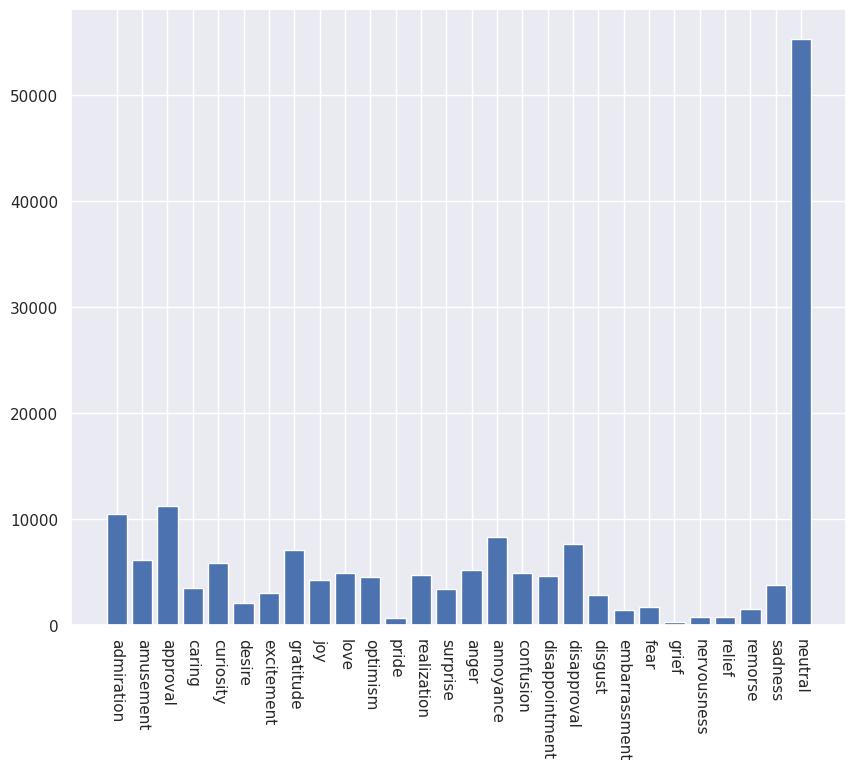

In [11]:
plt.figure(figsize=(10,8))
plt.bar(x=emotions_count.keys(), height=emotions_count.values())
plt.xticks(rotation=-90)
plt.show

Como os dados não estão balanceados, iremos pensar em eliminar algumas labels/emoções da classe positiva.

In [12]:
threshold = 5000
ids = []
for emotion in list_emotions:
    if emotions_count[emotion] > threshold:
        ids += df[df[emotion] == 1].sample(threshold).index.to_list()
    else:
        ids += df[df[emotion] == 1].index.to_list()
print(f"Assim, possuimos cerca de {len(ids)/len(list_emotions)} amostras por classe")

Assim, possuimos cerca de 3550.4285714285716 amostras por classe


In [13]:
print(f'Número de amostras mantidas: {len(ids)}')

Número de amostras mantidas: 99412


In [14]:
df_balanced = df[df.index.isin(ids)]
len(df_balanced)

99412

In [15]:
emotions_count = {}
for emotion in list_emotions:
    emotions_count[emotion] = df_balanced[emotion].value_counts().to_dict()[1]
emotions_count

{'admiration': 5000,
 'amusement': 5000,
 'approval': 5000,
 'caring': 3523,
 'curiosity': 5000,
 'desire': 2147,
 'excitement': 3020,
 'gratitude': 5000,
 'joy': 4329,
 'love': 4957,
 'optimism': 4519,
 'pride': 690,
 'realization': 4714,
 'surprise': 3472,
 'anger': 5000,
 'annoyance': 5000,
 'confusion': 4938,
 'disappointment': 4706,
 'disapproval': 5000,
 'disgust': 2914,
 'embarrassment': 1433,
 'fear': 1778,
 'grief': 351,
 'nervousness': 796,
 'relief': 788,
 'remorse': 1510,
 'sadness': 3827,
 'neutral': 5000}

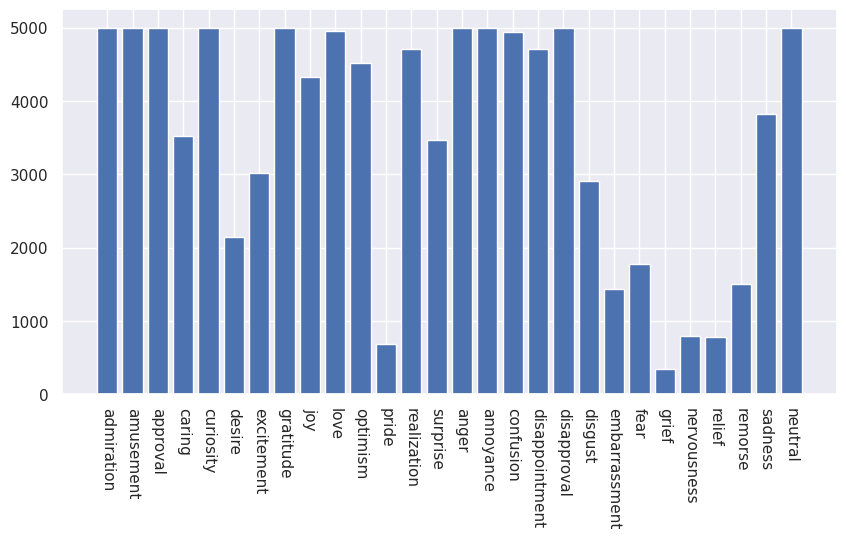

In [16]:
plt.figure(figsize=(10,5))
plt.bar(x=emotions_count.keys(), height=emotions_count.values())
plt.xticks(rotation=-90)
plt.show()

Os dados estão mais equilibrados

#### **Pré-processamento**

In [19]:
def preprocess_with_emojis(text):
    preprocessed_text = re.sub(r'http\S+', '', text) # removendo links
    preprocessed_text = preprocessed_text.replace('"', '')    # removendo aspas
    preprocessed_text = re.sub("[-*!,$><:.+?=]", '', preprocessed_text) # remove outras pontuações

    preprocessed_text = re.sub(r'[.]\s+', '', preprocessed_text)  # removendo reticências 
    emojis = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    preprocessed_text = re.sub(emojis, ' ', preprocessed_text) # removendo emojis
    preprocessed_text = re.sub(r'  ', ' ', preprocessed_text) # removendo espaços extras
    
    return preprocessed_text.lower()  

def pre_process_text(text):
    preprocessed_text = re.sub(r'http\S+', '', text) # removendo links
    preprocessed_text = preprocessed_text.replace('"', '')    # removendo aspas
    preprocessed_text = re.sub("[-*!,$><:.+?=]", '', preprocessed_text) # remove outras pontuações
    
    preprocessed_text = re.sub(r'[.]\s+', '', preprocessed_text)  # removendo reticências 
    preprocessed_text = re.sub(r'  ', ' ', preprocessed_text) # removendo espaços extras
    
    return preprocessed_text.lower()

In [20]:
df_balanced['text'] = df_balanced['text'].apply(pre_process_text, 1)
df_balanced.head()

/tmp/ipykernel_32718/1539554176.py:1: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_balanced['text'] = df_balanced['text'].apply(pre_process_text, 1)
/tmp/ipykernel_32718/1539554176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_balanced['text'] = df_balanced['text'].apply(pre_process_text, 1)


,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,num_labels
0,eew5j0j,that game hurt,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,eeibobj,man i love reddit,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,eespn2i,right considering it’s such an important docum...,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,ed5tx8y,that's crazy; i went to a super [religion] hig...,False,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,ef961hv,that's adorable asf,False,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
df_balanced.to_csv("../data/processed_go_emotions.csv",index=False)

## **Carregando tokenizer e modelo**

In [ ]:
base = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(base)

In [ ]:
df_tokenized = tokenizer(df_labeled['preprocessed_text'].to_list(), return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH)

In [ ]:
df_tokenized.keys()

In [ ]:
print(df_tokenized['input_ids'].shape, df_tokenized['attention_mask'].shape)

In [ ]:
def compute_metrics(eval_pred):
    load_accuracy = evaluate.load('accuracy')
    load_f1 = evaluate.load('f1')

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

### **Dataloader**

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(y)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.X.items()} 
        item['labels'] = self.y[idx]
        return item

In [ ]:
dataset = TextDataset(df_tokenized, torch.tensor(df_labeled['imdb_label'].to_numpy()))

In [ ]:
n_train_instances = int(np.round(dataset.len * TRAIN_RATIO))
n_val_instances = int(np.round(dataset.len * VAL_RATIO))
n_test_instances = int(np.round(dataset.len * TEST_RATIO))
print(f'Treino: {n_train_instances}, Val.: {n_val_instances}, Teste: {n_test_instances}')

In [ ]:
train_split, val_split, test_split = torch.utils.data.random_split(dataset, [n_train_instances, n_val_instances, n_test_instances])

## **Treinando com framework trainer**

In [ ]:
model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_attentions=False, output_hidden_states=False)
model.to(device)

In [ ]:
repo_name = "./finetuning-sentiment-go-emotions"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   evaluation_strategy='epoch',
   save_total_limit=5
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_split,
   eval_dataset=val_split,
   tokenizer=tokenizer,
   data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
   compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
torch.save(model.state_dict(), './model_weights_trainer.pth')

## **Training with training loop**

In [ ]:
train_loader = torch.utils.data.DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
epochs = 5
steps_per_epoch = 200
epoch_validation_samples = 50

model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_attentions=False, output_hidden_states=False)
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
def model_step(model, batch_data, cur_step, compute_evaluation=False, optimizer=None):
    if cur_step == 'train':
        model.train()
    elif cur_step == 'val':
        model.eval()
    
    input_ids = batch_data['input_ids'].to(device)
    attention_mask = batch_data['attention_mask'].to(device)
    labels = batch_data['labels'].to(device)

    output = model(input_ids, attention_mask=attention_mask, labels=labels.long())
    
    loss = output.loss
    logits = output.logits

    if cur_step == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    evaluation = None
    if compute_evaluation:
        softmax_predictions = torch.nn.functional.softmax(logits, dim=1)
        evaluation = compute_metrics([softmax_predictions.detach().cpu(), labels])

    return loss.item() * labels.shape[0], evaluation

In [ ]:
epoch_data = {}

for i in range(epochs):
    epoch_data[i] = {'train': [], 'validation': []}
    num_train_examples = 0
    num_val_examples = 0

    train_hits = 0
    val_hits = 0

    train_bar = tqdm(total=len(train_loader), desc=f"Train", unit="steps", position=0, leave=False)
    val_bar   = tqdm(total=epoch_validation_samples, desc=f"Validation", unit="samples", position=0, leave=False)

    train_running_loss = 0
    for batch_id, batch_data in enumerate(train_loader):
        if (batch_id + 1) % 500 == 0:
            loss, evaluation = model_step(model, batch_data, 'train', True, optim)
            epoch_data[i]['train'].append(evaluation)
        else:
            loss, _ = model_step(model, batch_data, 'train', False, optim)

        train_running_loss += loss

        train_bar.update(1)

    val_running_loss = 0
    for batch_id, batch_data in enumerate(val_loader):
        loss, evaluation = model_step(model, batch_data, 'val', True)
        
        val_running_loss += loss

        epoch_data[i]['validation'].append(evaluation)
        
        val_bar.update(1)

        if (batch_id + 1) % epoch_validation_samples == 0:
            break
    
    train_acc = np.mean([eval['accuracy'] for eval in epoch_data[i]['train']])
    val_acc = np.mean([eval['accuracy'] for eval in epoch_data[i]['validation']])
    
    train_loss = train_running_loss / len(train_loader.sampler)
    valid_loss = val_running_loss / len(val_loader.sampler)

    print(f"Epoch summary [{i+1}/{epochs}]\t Train loss: {train_loss}\t Train acc: {train_acc}\t Val loss: {valid_loss}\t Val acc: {val_acc}")

In [ ]:
torch.save(model.state_dict(), './model_weights_loop.pth')

## **Avaliando modelo no IMDB**

In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import evaluate

from transformers import AutoTokenizer
from transformers import BertForSequenceClassification
# from transformers import TrainingArguments, Trainer
# from transformers import DataCollatorWithPadding

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

In [ ]:
torch.__version__

In [ ]:
import torch
torch.__version__

In [ ]:
import torchaudio
torchaudio.__version__

In [ ]:
import torchvision
torchvision.__version__

In [ ]:
state_dict = torch.load('model_weights_loop.pth')

In [ ]:
state_dict = {k: v for k,v in state_dict.items() if k != 'bert.embeddings.position_ids'}

In [ ]:
model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_attentions=False, output_hidden_states=False)
model.load_state_dict(state_dict)
model.to(device)

In [ ]:
df_imdb = pd.read_csv('IMDB_Dataset.csv')

In [ ]:
df_imdb.head()

In [ ]:
df_imdb['sentiment'].unique()

In [ ]:
df_imdb['label'] = df_imdb.apply(lambda x: 1 if x.loc['sentiment'] == 'positive' else 0, axis=1)

In [ ]:
def preprocess_with_emojis(text):
    preprocessed_text = re.sub(r'http\S+', '', text) # removendo links
    preprocessed_text = preprocessed_text.replace('"', '')    # removendo aspas
    preprocessed_text = re.sub("[-*!,$><:.+?=]", '', preprocessed_text) # remove outras pontuações

    preprocessed_text = re.sub(r'[.]\s+', '', preprocessed_text)  # removendo reticências 
    # emojis = re.compile("["
    #     u"\U0001F600-\U0001F64F"  # emoticons
    #     u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    #     u"\U0001F680-\U0001F6FF"  # transport & map symbols
    #     u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    #     u"\U00002500-\U00002BEF"  # chinese char
    #     u"\U00002702-\U000027B0"
    #     u"\U00002702-\U000027B0"
    #     u"\U000024C2-\U0001F251"
    #     u"\U0001f926-\U0001f937"
    #     u"\U00010000-\U0010ffff"
    #     u"\u2640-\u2642" 
    #     u"\u2600-\u2B55"
    #     u"\u200d"
    #     u"\u23cf"
    #     u"\u23e9"
    #     u"\u231a"
    #     u"\ufe0f"  # dingbats
    #     u"\u3030"
    #                   "]+", re.UNICODE)
    # preprocessed_text = re.sub(emojis, ' ', preprocessed_text) # removendo emojis
    preprocessed_text = re.sub(r'  ', ' ', preprocessed_text) # removendo espaços extras
    
    return preprocessed_text.lower()  

def pre_process_text(text):
    preprocessed_text = re.sub(r'http\S+', '', text) # removendo links
    preprocessed_text = preprocessed_text.replace('"', '')    # removendo aspas
    preprocessed_text = re.sub(r"<\S*\ ?\/?>", '', preprocessed_text)
    preprocessed_text = re.sub("[-*!,$><:.+?=]", '', preprocessed_text) # remove outras pontuações

    preprocessed_text = re.sub(r'[.]\s+', '', preprocessed_text)  # removendo reticências 
    preprocessed_text = re.sub(r'  ', ' ', preprocessed_text) # removendo espaços extras
    
    return preprocessed_text.lower()

In [ ]:
df_imdb['preprocessed_text'] = df_imdb['review'].apply(pre_process_text)

In [ ]:
df_imdb.head()

In [ ]:
base = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(base)

In [ ]:
imdb_tokenized = tokenizer.encode(df_imdb['preprocessed_text'].to_list(), return_tensors='pt', padding=True, truncation=True)

In [ ]:
imdb_tokenized

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(y)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.X.items()} 
        item['labels'] = self.y[idx]
        return item

In [ ]:
dataset = TextDataset(imdb_tokenized, torch.tensor(df_imdb['label'].to_numpy()))

In [ ]:
imdb_tokenized.keys()

In [ ]:
imdb_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
len(imdb_dataloader)

In [ ]:
next(iter(imdb_dataloader))

In [ ]:
metric = evaluate.load("accuracy")

bar = tqdm(total=len(imdb_dataloader), desc=f"Evaluation on imdb-dataset", unit="steps", position=0, leave=False)

model.eval()
for batch in imdb_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    print(batch.keys())
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    bar.update(1)
metric.compute()

In [ ]:
outputs

## TODO: 
- Mudar de classes binárias (positivo/negativo) para múltiplas classes: alegria, tristeza, raiva,...
- Incrementar e pesquisar mais sobre o pré-processamento para modelos de linguagem natural + BERT
- Treinar o modelo
- Comparar resultados de alguma forma com o IMDB_dataset